In [1]:
# initialization
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

In [2]:
# set the length of the n-bit input string. 
n = 3

const_oracle = QuantumCircuit(n+1)

output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)

a = const_oracle.draw()
print(a)

     
q_0: 
     
q_1: 
     
q_2: 
     
q_3: 
     


In [3]:
# Quantum Oracle Implementation
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)
balanced_oracle.draw()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Show oracle
balanced_oracle.draw()

┌───┐     ┌───┐          
q_0: ┤ X ├──■──┤ X ├──────────
     └───┘  │  └───┘          
q_1: ───────┼────■────────────
     ┌───┐  │    │       ┌───┐
q_2: ┤ X ├──┼────┼────■──┤ X ├
     └───┘┌─┴─┐┌─┴─┐┌─┴─┐└───┘
q_3: ─────┤ X ├┤ X ├┤ X ├─────
          └───┘└───┘└───┘

In [4]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit.compose(balanced_oracle, inplace=True)
dj_circuit.barrier()
dj_circuit.x(n)

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw()

┌───┐┌───┐     ┌───┐           ░ ┌───┐ ░ ┌─┐      
q_0: ┤ H ├┤ X ├──■──┤ X ├───────────░─┤ H ├─░─┤M├──────
     ├───┤└───┘  │  └───┘           ░ ├───┤ ░ └╥┘┌─┐   
q_1: ┤ H ├───────┼────■─────────────░─┤ H ├─░──╫─┤M├───
     ├───┤┌───┐  │    │       ┌───┐ ░ ├───┤ ░  ║ └╥┘┌─┐
q_2: ┤ H ├┤ X ├──┼────┼────■──┤ X ├─░─┤ H ├─░──╫──╫─┤M├
     ├───┤├───┤┌─┴─┐┌─┴─┐┌─┴─┐└───┘ ░ ├───┤ ░  ║  ║ └╥┘
q_3: ┤ X ├┤ H ├┤ X ├┤ X ├┤ X ├──────░─┤ X ├─░──╫──╫──╫─
     └───┘└───┘└───┘└───┘└───┘      ░ └───┘ ░  ║  ║  ║ 
c: 3/══════════════════════════════════════════╩══╩══╩═
                                               0  1  2

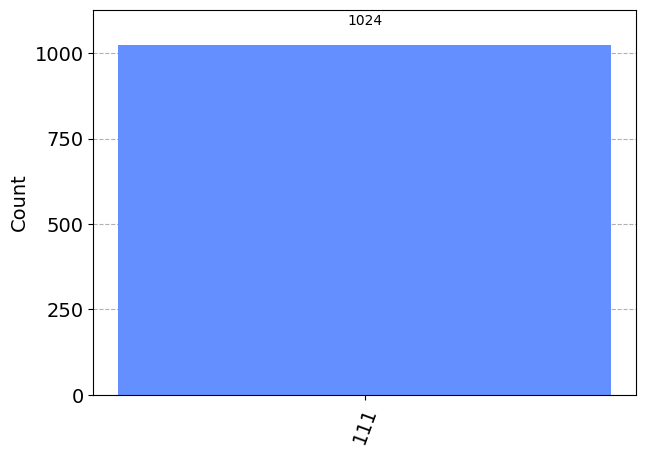

In [10]:
# use local simulator
sim = Aer.get_backend('qasm_simulator')
results = sim.run(transpile(dj_circuit,sim)).result()
answer = results.get_counts()
plot_histogram(answer)

In [11]:
# Generalized Oracles
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

In [12]:
# Generalized Algorithm

def dj_algorithm(oracle, n):
    
    dj_circuit = QuantumCircuit(n+1, n)
    
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    
    # Set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
        
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

In [13]:
n = 4
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()

┌───┐     ┌─────────┐┌───┐┌─┐         
q_0: ┤ H ├─────┤0        ├┤ H ├┤M├─────────
     ├───┤     │         │├───┤└╥┘┌─┐      
q_1: ┤ H ├─────┤1        ├┤ H ├─╫─┤M├──────
     ├───┤     │         │├───┤ ║ └╥┘┌─┐   
q_2: ┤ H ├─────┤2 Oracle ├┤ H ├─╫──╫─┤M├───
     ├───┤     │         │├───┤ ║  ║ └╥┘┌─┐
q_3: ┤ H ├─────┤3        ├┤ H ├─╫──╫──╫─┤M├
     ├───┤┌───┐│         │└───┘ ║  ║  ║ └╥┘
q_4: ┤ X ├┤ H ├┤4        ├──────╫──╫──╫──╫─
     └───┘└───┘└─────────┘      ║  ║  ║  ║ 
c: 4/═══════════════════════════╩══╩══╩══╩═
                                0  1  2  3

## Reglas Metamórficas

El programa anteriormente descrito toma una función *f* y devuelve 1 si dicha función es constante, 0 si es balanceada.

1. Sea *g* un automorfismo de {0,1}^n, entonces P(*f(x)*) = P(*f(g(x))*).
2. P(*f(x)*) = P(1 - *f(x)*).
3. 1 = P(*rnd(f(x))*). Donde *rnd* es una función que toma un bloque de 0's y manda la mitad de ellos a 1, y actúa de forma análoga sobre el bloque de 1's.

In [14]:
# 1. Donde n=3 y g es la función biyectiva que invierte dígitos

n = 3
dj_circuit = QuantumCircuit(2*n+2, 2*n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
    
for qubit in range(n+1,2*n+1):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)
dj_circuit.x(2*n+1)
dj_circuit.h(2*n+1)

# Place X-gates
for qubit in range(n+1,2*n+1):
    if b_str[qubit%n - 1] == '0':
        dj_circuit.x(qubit)

# Add oracle
dj_circuit.compose(balanced_oracle, inplace=True)

for qubit in range(n+1,2*n+1):
    dj_circuit.cx(qubit, 2*n+1)

# Place X-gates
for qubit in range(n+1,2*n+1):
    if b_str[qubit%n - 1] == '0':
        dj_circuit.x(qubit)
    
# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
    
# Repeat H-gates
for qubit in range(n+1,2*n+1):
    dj_circuit.h(qubit)
    
dj_circuit.barrier()

dj_circuit.cx(4,0)
dj_circuit.cx(5,1)
dj_circuit.cx(6,2)

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw()


┌───┐┌───┐     ┌───┐┌───┐           ░ ┌───┐          ┌─┐      
q_0: ┤ H ├┤ X ├──■──┤ X ├┤ H ├───────────░─┤ X ├──────────┤M├──────
     ├───┤└───┘  │  └───┘├───┤           ░ └─┬─┘┌───┐     └╥┘┌─┐   
q_1: ┤ H ├───────┼────■──┤ H ├───────────░───┼──┤ X ├──────╫─┤M├───
     ├───┤┌───┐  │    │  └───┘┌───┐┌───┐ ░   │  └─┬─┘┌───┐ ║ └╥┘┌─┐
q_2: ┤ H ├┤ X ├──┼────┼────■──┤ X ├┤ H ├─░───┼────┼──┤ X ├─╫──╫─┤M├
     ├───┤├───┤┌─┴─┐┌─┴─┐┌─┴─┐└───┘└───┘ ░   │    │  └─┬─┘ ║  ║ └╥┘
q_3: ┤ X ├┤ H ├┤ X ├┤ X ├┤ X ├───────────░───┼────┼────┼───╫──╫──╫─
     ├───┤└───┘└───┘├───┤└───┘           ░   │    │    │   ║  ║  ║ 
q_4: ┤ H ├───────■──┤ H ├────────────────░───■────┼────┼───╫──╫──╫─
     ├───┤┌───┐  │  └───┘┌───┐┌───┐      ░        │    │   ║  ║  ║ 
q_5: ┤ H ├┤ X ├──┼────■──┤ X ├┤ H ├──────░────────■────┼───╫──╫──╫─
     ├───┤└───┘  │    │  └───┘├───┤      ░             │   ║  ║  ║ 
q_6: ┤ H ├───────┼────┼────■──┤ H ├──────░─────────────■───╫──╫──╫─
     ├───┤┌───┐┌─┴─┐┌─┴─┐┌─┴─┐└───┘      ░                 ║  ║  ║ 
q_7: ┤ X ├┤ H ├┤ X ├┤ X ├┤ X ├───────────░─────────────────╫──╫──╫─
     └───┘└───┘└───┘└───┘└───┘           ░                 ║  ║  ║ 
c: 6/══════════════════════════════════════════════════════╩══╩══╩═
                                                           0  1  2

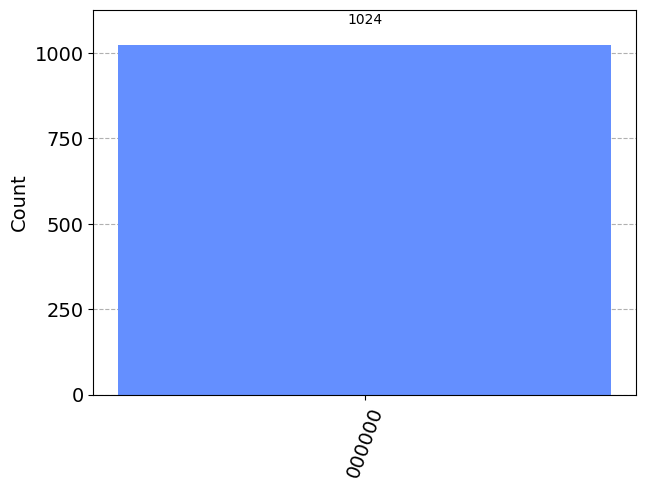

In [16]:
# use local simulator
sim = Aer.get_backend('qasm_simulator')
results = sim.run(transpile(dj_circuit,sim)).result()
answer = results.get_counts()
plot_histogram(answer)